# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**

This project aims to forecast national monthly car sales in South Africa (who: automotive industry stakeholders) by integrating historical vehicle sales data with behavioral signals from Google Trends search indices (what). Using data spanning from 2010 Jan to 2025 Jan (when) and focusing on the South African automotive market (where), the study addresses why traditional forecasting methods—based only on past sales—often fail to capture rapid shifts in consumer interest and external market changes. To overcome this, the research compares traditional time-series models (SARIMA, LSSVR) with deep learning models (LSTM, CNN-LSTM, BiLSTM), both with and without online search data, to evaluate the added predictive value of behavioral signals (how). Finally, the best-performing deep learning models are interpreted using SHAP analysis to reveal which features most influence forecasts, supporting more data-driven, transparent, and responsive decision-making for manufacturers, dealerships, and analysts.


## 1. Libraries

In [2]:
# ! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl

In [ ]:
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, joblib
import openpyxl
import tensorflow as tf
import keras

# Deep learning
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Bidirectional
from keras.callbacks import EarlyStopping

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR

## 2. Importing datasets

In [ ]:
df = pd.read_excel("Overall Sales.xlsx")

text = pd.read_csv("./GoogleTrends/multiTimeline.csv")

In [ ]:
# Transpose the DataFrame to have periods as rows
sales = df.transpose() 

# Set the first row as the header
sales.rename(columns=sales.iloc[0], inplace=True) 

# Remove the first row which is now the header
sales = sales[1:] 

# Rename the columns for clarity
sales.rename(columns={'Country / Region': 'Period', 'South Africa': 'Sales'}, inplace=True) 

# Converts the 'Period' column to datetime
sales['Period'] = pd.to_datetime(sales['Period'], format='%Y%m', exact = True) 

# Converts to monthly period and then to end of each month
sales['Period'] = sales['Period'].dt.to_period('M').dt.to_timestamp('M')

# Set the 'Period' column as the index
sales.set_index(sales.columns[0], inplace=True) 

# Convert 'Sales' column to numeric type
sales['Sales'] = pd.to_numeric(sales['Sales']) 

sales.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2010-01-31 to 2025-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   181 non-null    int64
dtypes: int64(1)
memory usage: 2.8 KB


In [6]:
sales

,Sales
Period,
2010-01-31,32851
2010-02-28,32555
2010-03-31,36134
2010-04-30,28877
2010-05-31,31248
...,...
2024-09-30,43995
2024-10-31,47990
2024-11-30,48557


## 3. Data Understanding

### a. Statistical Description

In [7]:
sales.describe()

,Sales
count,181.000000
mean,45218.961326
std,8005.009913
min,574.000000
25%,40843.000000
50%,46015.000000
75%,50386.000000
max,60817.000000


In [8]:
print(sales.query("Sales == 574 or Sales == 60817"))

            Sales
Period           
2014-09-30  60817
2020-04-30    574


##### *Interpretation:*

+ There were a total of 181 months taken into account (Jan 2010 - Jan 2025)
+ There were 45 218 vehicles sold each month on average with a  of 8005 less or more sales
+ April 2020 reported the least amount of sales (574) and September 2014 reported the most amount of sales (60 817)

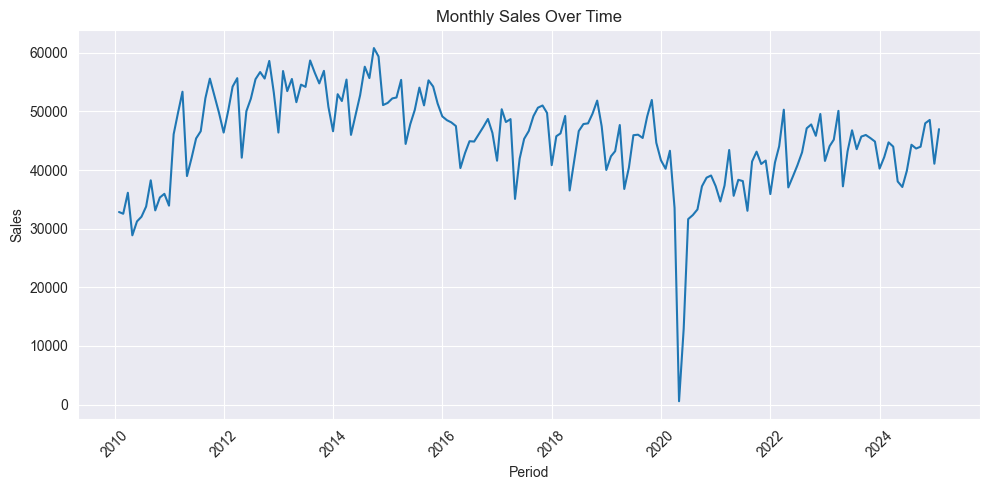

In [9]:
# Plot linegraph of sales over time
plt.figure(figsize=(10,5))
sns.lineplot(x='Period', y='Sales', data=sales)
plt.title('Monthly Sales Over Time')
plt.xlabel('Period')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### *Interpretation:*

The graph shows an increase in sales for the early years of the 2010's (2010-2012), followed by a slight decrease from 2014-2016. It ended up stagnating for majority of the years from 2016 onwards with a sharp decline in the early months of 2020. This sharp decline was caused by the shut down of the country due to the Covid-19 Pandemic.[https://www.cars.co.za/motoring-news/new-car-sales-in-sa-march-2020/77385/]

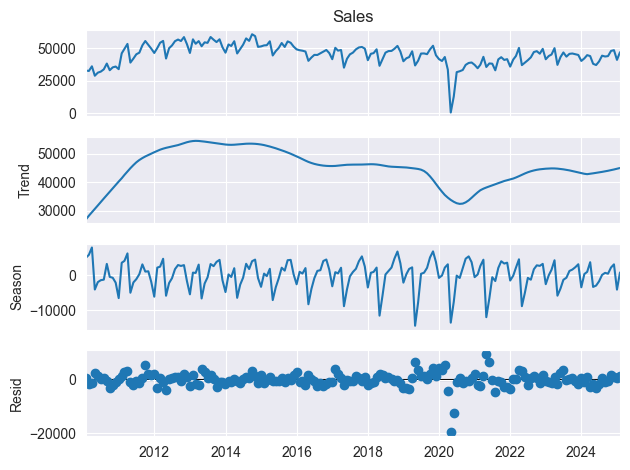

In [10]:
stl = STL(sales['Sales'], period=12)
result = stl.fit()
result.plot()
plt.show()

##### **Intepretation:**
##### *Trend - Shows us the longterm movement of the sales*
+ From 2010-2014 there was a steady upward trend then from 2014-2018 it slowsdown and flattens with a minor dip between 2016-2018
+ In 2020 there was a sharp dip in the trend due to the Covid-19 Pandemic, where it only started to recover at the start of 2022

#### *Seasonality - shows us the repeating yearly patterns*
+ There are Consistent peaks and dips that follow a regular yearly rhythm.

#### *Residual - shows what's left after removing the trend and seasonality*
+ The residual is mostly well contained around y = 0 (i.e. sales = 0) but except at the 2020 crisis.
+ This suggest that noise is reasonably low and stable which indicates a well-behaved time series.

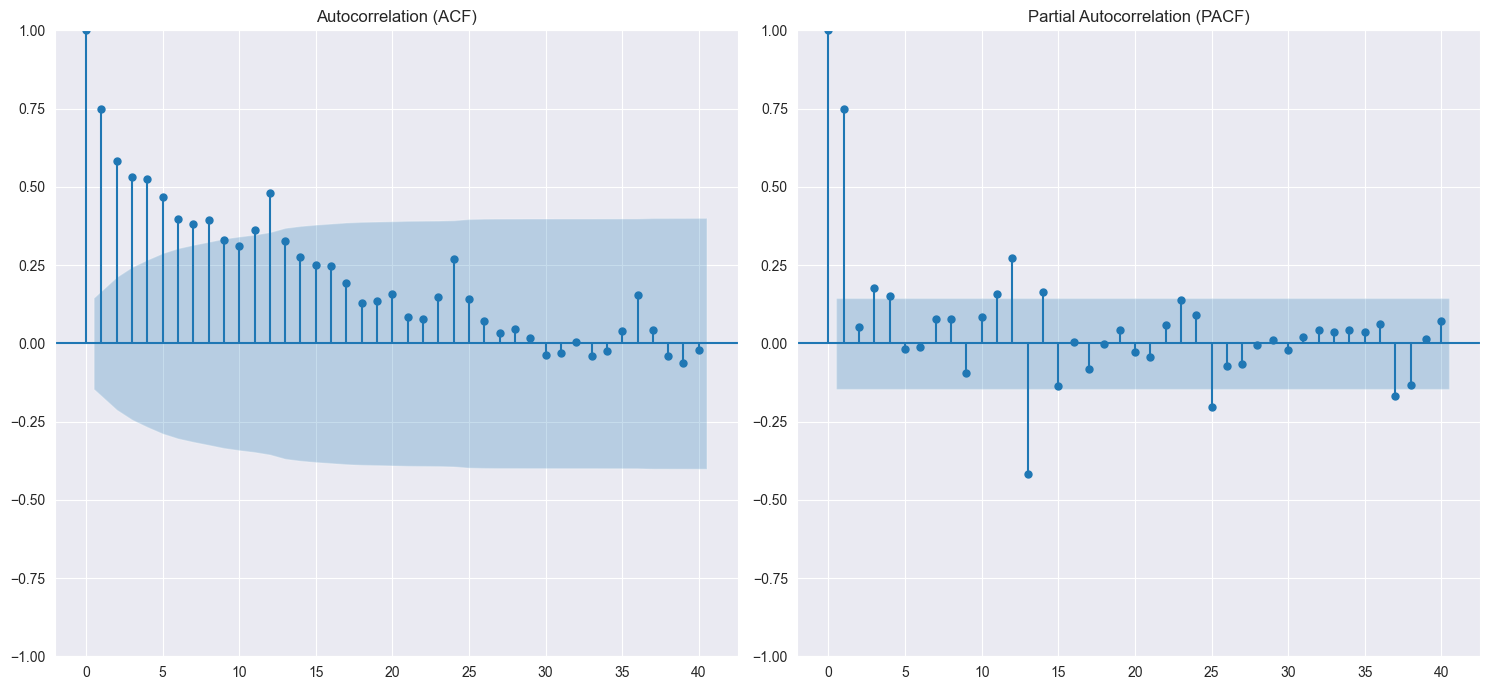

In [11]:
plt.figure(figsize=(15,7))

# Plot ACF on the left
plt.subplot(1, 2, 1)
plot_acf(sales['Sales'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation (ACF)')

# Plot PACF on the right
plt.subplot(1, 2, 2)
plot_pacf(sales['Sales'], ax=plt.gca(), lags=40, method='ywm')
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

In [12]:
adf_result = adfuller(sales['Sales'])
print(f"ADF p-value: {adf_result[1]}")

ADF p-value: 0.3598280115712067
